In [19]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

In [20]:
# MNIST dataset parameters
num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features in our input (28*28 = 784)

# Training parameters
learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

# Neural Network parameters
n_hidden_1 = 128 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons

In [21]:
# Prepare MNIST data.

# download the dataset

from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Flatten images to 1-D vector of 784 features (28* 28)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize image values from [0, 255] ---> [0, 1]
x_train, x_test = x_train / 255. , x_test / 255.

#### To shuffle data

In [22]:
# Use tf.data API to shuffle and batch data

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [23]:
# store layers weights and biases
# A random number generator to intialize weights

random_normal = tf.initializers.RandomNormal()

weights = {
    "h1": tf.Variable(random_normal([num_features, n_hidden_1])),
    "h2": tf.Variable(random_normal([n_hidden_1, n_hidden_2])),
    "out": tf.Variable(random_normal([n_hidden_2, num_classes]))
}

biases = {
    "b1": tf.Variable(random_normal([n_hidden_1])),
    "b2": tf.Variable(random_normal([n_hidden_2])),
    "out": tf.Variable(random_normal([num_classes]))
}

In [25]:
print("Shape W_1: ", weights["h1"].shape)
print("Shape W_2: ", weights["h2"].shape)
print("Shape W_Out: ", weights["out"].shape)

print("Shape B_1: ", biases["b1"].shape)
print("Shape B_2: ", biases["b2"].shape)
print("Shape B_Out: ", biases["out"].shape)


Shape W_1:  (784, 128)
Shape W_2:  (128, 256)
Shape W_Out:  (256, 10)
Shape B_1:  (128,)
Shape B_2:  (256,)
Shape B_Out:  (10,)


### Create model

In [26]:
# Create model

def neural_net(x):
  # Hidden fully connected layer with 128 neurons.
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) # Z1
  # Apply sigmoid to layer_1 output for non-linearity
  layer_1 = tf.nn.sigmoid(layer_1) # A1

  # Hidden fully connected layer with 256 neurons.
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # Z2
  # apply sigmoid to layer_2 output
  layer_2 = tf.nn.sigmoid(layer_2) # A2

  # Output fully connected layer with a neuron for each class --> 10
  out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # Z3

  # Apply softmax to normalize the logits to a probablity distribution
  return tf.nn.softmax(out_layer)



In [27]:
# Cross-Entropy loss function
def cross_entropy(y_pred, y_true):
  # Encode label to a one hot vector
  y_true = tf.one_hot(y_true, depth = num_classes)

  # Clip predictions values to avoid log(0) error.

  y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

  # Compute cross-entropy loss

  return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metrics
def accuracy(y_pred, y_true):
  # Predicted class is the index of highest score in prediction vector( ie argmax)
  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer
optimizer = tf.optimizers.SGD(learning_rate)

In [28]:
# Optimizing process
def run_optimization(x ,y):
  # Wrap computation inside a GradientTape for automatic differentiation

  with tf.GradientTape() as g:
    pred = neural_net(x)
    loss = cross_entropy(pred, y)

  # Variable to update ie trainable variables during back propagation

  trainable_variables = list(weights.values()) + list(biases.values())

  #Compute graidents
  gradients = g.gradient(loss, trainable_variables)

  # Update W and b following gradients
  optimizer.apply_gradients(zip(gradients, trainable_variables))


In [29]:
# Run training for the give number of steps
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
  # Run the optmizatoin top update W and b values after each batch
  run_optimization(batch_x, batch_y)

  if step % display_step == 0:
    pred = neural_net(batch_x)
    loss = cross_entropy(pred, batch_y)
    acc = accuracy(pred, batch_y)

    print(f"step: {step}, loss: {loss}, accuracy: {acc}")


step: 100, loss: 562.1680908203125, accuracy: 0.1640625
step: 200, loss: 410.6884765625, accuracy: 0.578125
step: 300, loss: 258.44091796875, accuracy: 0.73046875
step: 400, loss: 182.953857421875, accuracy: 0.796875
step: 500, loss: 132.50186157226562, accuracy: 0.859375
step: 600, loss: 140.16445922851562, accuracy: 0.828125
step: 700, loss: 105.21794128417969, accuracy: 0.875
step: 800, loss: 115.20463562011719, accuracy: 0.87890625
step: 900, loss: 125.50267028808594, accuracy: 0.83984375
step: 1000, loss: 109.79513549804688, accuracy: 0.87890625
step: 1100, loss: 73.10803985595703, accuracy: 0.9140625
step: 1200, loss: 64.4562759399414, accuracy: 0.93359375
step: 1300, loss: 63.310546875, accuracy: 0.91796875
step: 1400, loss: 71.7698974609375, accuracy: 0.93359375
step: 1500, loss: 107.74415588378906, accuracy: 0.8828125
step: 1600, loss: 70.04397583007812, accuracy: 0.9140625
step: 1700, loss: 75.74697875976562, accuracy: 0.91796875
step: 1800, loss: 73.08412170410156, accuracy:

In [30]:
# Test mode on validations set

pred = neural_net(x_test)

print(f"Test accuracy: {accuracy(pred, y_test)}")

Test accuracy: 0.9351999759674072


In [31]:
# Visual perdiction comparison

import matplotlib.pyplot as plt

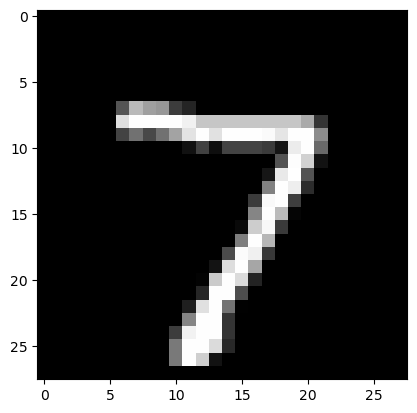

Model prediction: 7


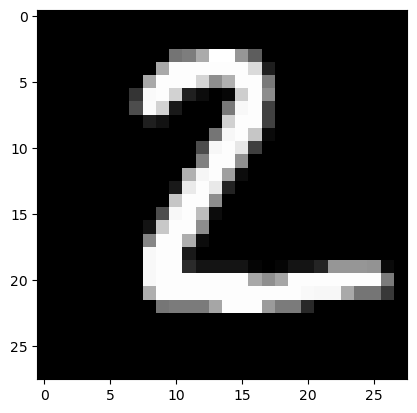

Model prediction: 2


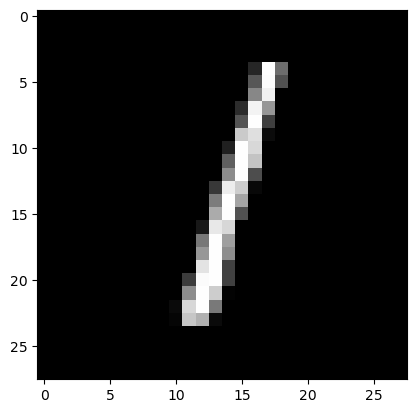

Model prediction: 1


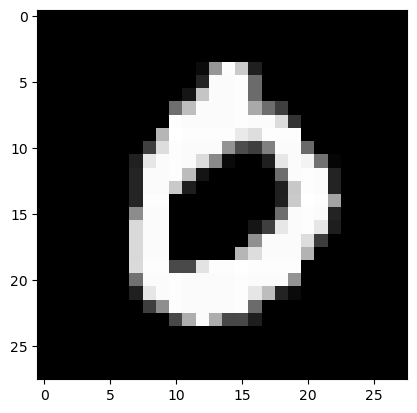

Model prediction: 0


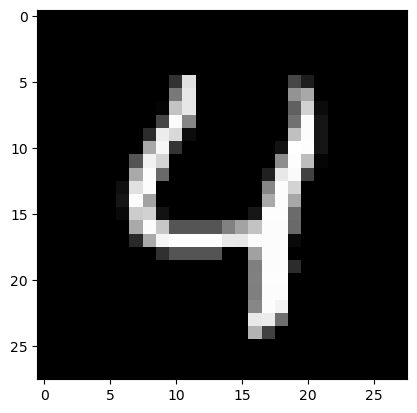

Model prediction: 4


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Predict 5 images from the validation set
n_images = 5

test_images = x_test[:n_images]  # Shape = [5, 784]

predictions = neural_net(test_images)  # Shape = [5, 10]

# Display image and model prediction
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print(f"Model prediction: {np.argmax(predictions.numpy()[i])}")
